In [3]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)

# Suppress pandas future-warning about categorical dtypes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load experimental data

In [67]:
# All data
# path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
path = '../../_Datasets/SPVGazeData/_preprocessed_org'
exp_data, calbr_data = data_processing.load_preprocessed_data(path)
subjects = data_processing.SUBJECTS # or specify subset of subjects
practice_trials = data_processing.PRACTICE_TRIALS
experimental_tasks = ['SceneRecognition']

/scratch/jaap/SPVGazeAnalysis/scene_recognition/./../data_processing.py:116: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')


In [68]:
# Select the trialconfig rows that contain (valid) scene recognition data
sr_data = data_processing.drop_invalid(exp_data['TrialConfigRecord'],
                                       exclude_trials = practice_trials,
                                       include_tasks = experimental_tasks,
                                       include_subjects = subjects)
sr_data = sr_data.astype({'ReportedSubjectiveRating':float, 'ReportedEventsCount':float})

### Calculate correct responses

In [69]:
# Previous observations and classification success as additional columns
sr_data['SeenBeforeCount'] = sr_data.groupby(['Subject', 'EnvironmentName']).cumcount()
sr_data['CorrectResponse'] = (sr_data.EnvironmentClass == sr_data.ReportedRoomCategory).astype(float)
sr_data['Session'] = (sr_data.Block>3).replace({False: 'FirstSession', True: 'SecondSession' })

### Data inspection (per subject)

In [5]:
# load data 
# sr_data = pd.read_csv('out/scene_recognition_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')

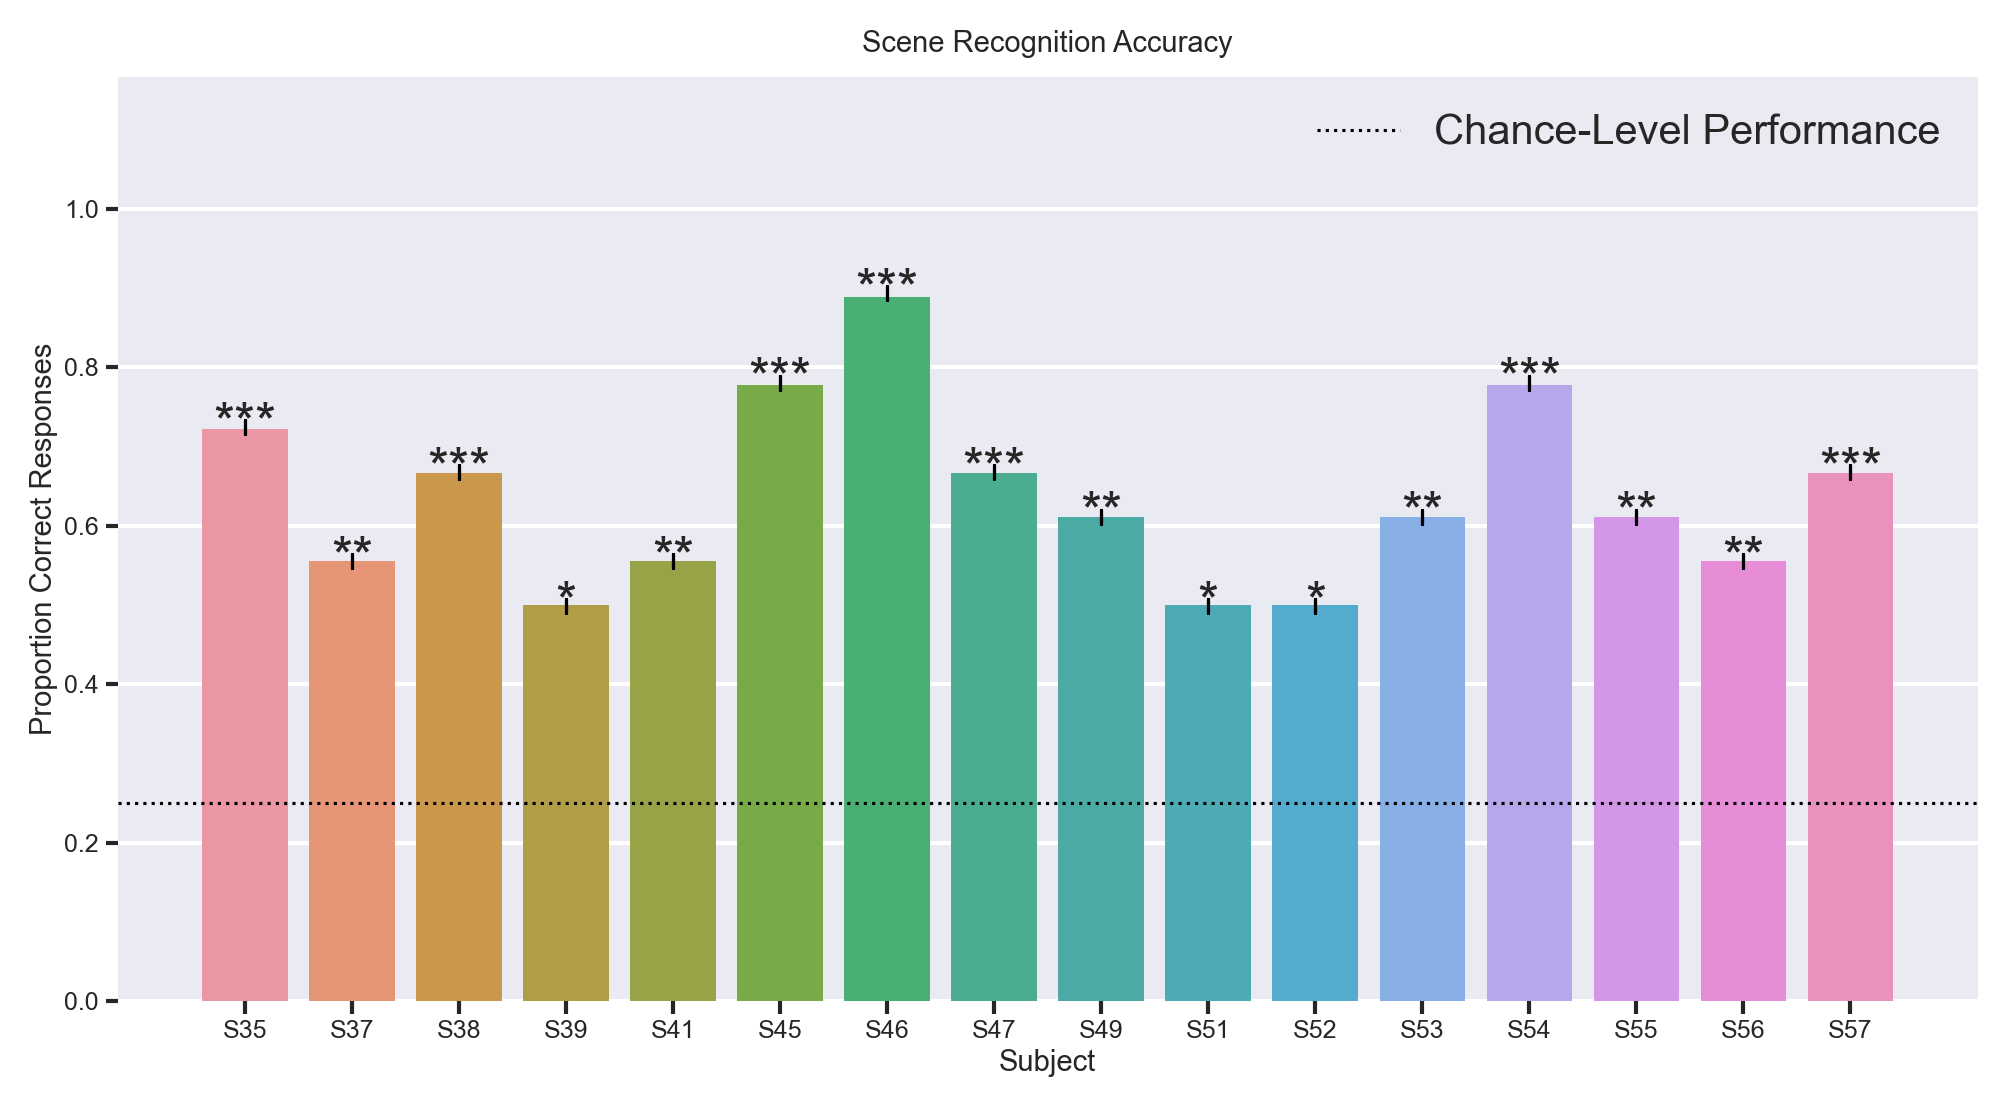

In [6]:
import scipy
importlib.reload(stats)

# Barplot per subject
visualization.set_figurestyle()
fig, ax = visualization.create_subplots(1, figsize=(8,4))
sns.barplot(x='Subject', y='CorrectResponse', data=sr_data, errorbar=None, ax=ax)
ax.set(title='Scene Recognition Accuracy', ylabel='Proportion Correct Responses')
h = ax.axhline(0.25, color='k', linestyle=':', label='Chance-Level Performance')
ax.legend(handles=[h,])


# Binomial test (significantly better than chance?)
correct_responses = sr_data.groupby('Subject')[['CorrectResponse']]
p_values = stats.binom_test(n_correct=correct_responses.sum(), n_total=correct_responses.count(), p=0.25)

# Draw significance stars
stars = p_values.apply(stats.count_significance_stars, alpha=0.05)
n_subjects = len(correct_responses)
visualization.add_significance_lines(ax,
                               text=stars.replace({'n.s.': None}).values,
                               x_pairs=[(i,i) for i in range(n_subjects)],
                               rel_y=0.87*correct_responses.mean().values,)

plt.savefig('out/scene_recognition_accuracy_per_subject.png')

##### Save output

In [82]:
# exclude_subjects = ['S40', 'S42', 'S50'] 

# if not os.path.exists('./out'):
#     os.makedirs('./out')
# sr_data.loc[~sr_data.Subject.isin(exclude_subjects)].to_csv('out/scene_recognition_trial_endpoints.tsv', sep='\t', index=False)

## Statistical analysis

In [7]:
# # load data 
sr_data = pd.read_csv('out/scene_recognition_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')

In [8]:
exclude_subjects = ['S40', 'S42', 'S50'] # list of subjects / None 
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

# Average over subjects 
avg = stats.average(sr_data, y=endpoints, group='Subject', x='GazeCondition')
if exclude_subjects is not None:
    avg = avg.loc[~avg.Subject.isin(exclude_subjects)]

# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3))

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    display('Results t-test:', stats.style(results_t_test, alpha=0.05/3))

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
# display('Merged results:', stats.style(stat_results, alpha=0.05/3))

'Normality test:'

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
GazeAssistedSampling,0.020388,0.445381,0.859902
GazeIgnored,0.044697,0.082303,0.121256
SimulationFixedToGaze,0.060432,0.784777,0.725368
AnyNonNormal,True,False,False


C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


'Results Wilcoxon:'

,CorrectResponse
Comparison,
Gaze Locked <> Gaze Contingent,0.577116
Gaze Contingent <> Gaze Ignored,0.006724
Gaze Locked <> Gaze Ignored,0.011874


'Results t-test:'

,TrialDuration,ReportedSubjectiveRating
Comparison,,
Gaze Locked <> Gaze Contingent,0.001211,0.000060
Gaze Contingent <> Gaze Ignored,0.060690,0.015627
Gaze Locked <> Gaze Ignored,0.000350,0.000047


In [9]:
avg.groupby('GazeCondition')[endpoints].mean()

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
GazeCondition,,,
GazeAssistedSampling,0.572917,51.425032,4.270833
GazeIgnored,0.791667,44.078206,4.864583
SimulationFixedToGaze,0.541667,63.024539,3.135417


In [10]:
# # Save results
# avg.to_csv('out/scene_recognition_averaged_endpoints.tsv', sep='\t')
# normality.to_csv('out/scene_recognition_normality_test.tsv', sep='\t')
# stat_results.to_csv('out/scene_recognition_paired_testing.tsv', sep='\t')

# import dataframe_image as dfi
# dfi.export(stat_results, 'out/stats_scene_recognition.png')

### Visualization

In [4]:
# Load data
avg = pd.read_csv('out/scene_recognition_averaged_endpoints.tsv', sep='\t')
normality = pd.read_csv('out/scene_recognition_normality_test.tsv', sep='\t')
stat_results = pd.read_csv('out/scene_recognition_paired_testing.tsv', sep='\t').set_index('Comparison')

In [6]:
stars = stat_results.applymap(stats.count_significance_stars)
stars

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
Comparison,,,
Gaze Locked <> Gaze Contingent,n.s.,**,***
Gaze Contingent <> Gaze Ignored,*,n.s.,*
Gaze Locked <> Gaze Ignored,*,**,***


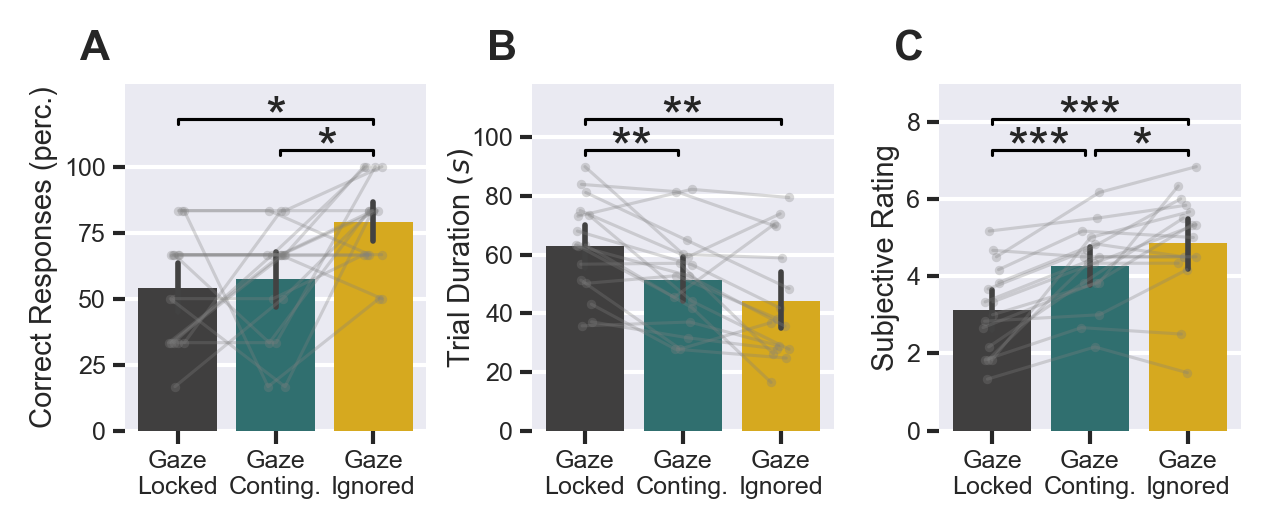

In [25]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 
titles = ['', '', '']#'Accuracy',  'Trial Duration', 'Subjective Rating']
y_lbls = ['Correct Responses (perc.)', 'Trial Duration $(s)$', 'Subjective Rating']

if avg['CorrectResponse'].max() <1.5:
    avg['CorrectResponse'] *=100

importlib.reload(visualization)
visualization.set_figurestyle()

fig,axs = visualization.create_subplots(figsize=(8*3/5,1.5))
fig,axs = visualization.bar_plots(avg, endpoints, fig=fig, axs=axs)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True, new_line=True)
# plt.tight_layout()

for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i],#'', #title=titles[i],
               ylabel=y_lbls[i],
               xticklabels = ['Gaze\nLocked', 'Gaze\nConting.', 'Gaze\nIgnored']
              )
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)
    
axs[0].set_yticks(np.linspace(0,100,5))

axs[1].set_ylabel(y_lbls[1],labelpad=-1)
    
visualization.add_panel_index(axs[0],'A')
visualization.add_panel_index(axs[1],'B')
visualization.add_panel_index(axs[2],'C')

plt.savefig('out/scene_recognition_endpoints.png', bbox_inches='tight')

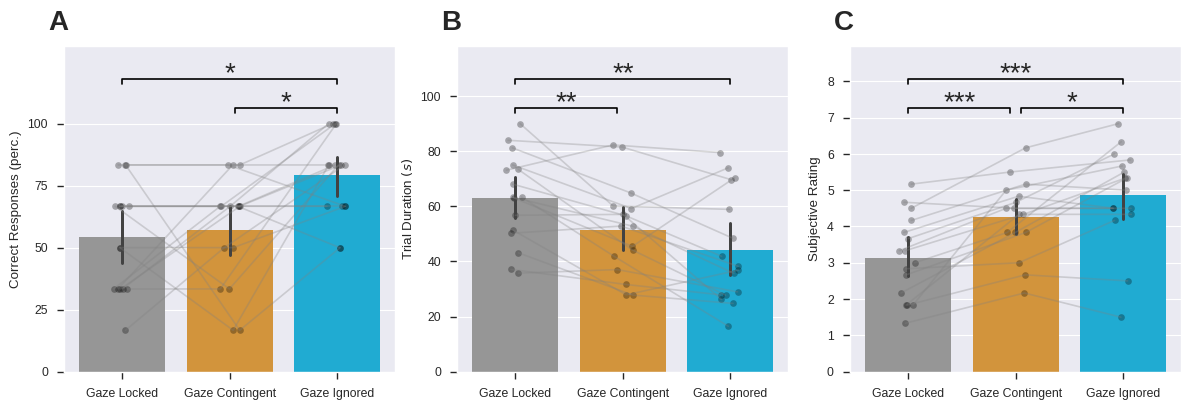

In [117]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 
titles = ['', '', '']#'Accuracy',  'Trial Duration', 'Subjective Rating']
y_lbls = ['Correct Responses (perc.)', 'Trial Duration $(s)$', 'Subjective Rating']

if avg['CorrectResponse'].max() <1.5:
    avg['CorrectResponse'] *=100

visualization.set_figurestyle()
fig,axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.tight_layout()

for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i],#'', #title=titles[i],
               ylabel=y_lbls[i])
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)
    
axs[0].set_yticks(np.linspace(0,100,5))
    
visualization.add_panel_index(axs[0],'A')
visualization.add_panel_index(axs[1],'B')
visualization.add_panel_index(axs[2],'C')

plt.savefig('out/scene_recognition_endpoints.png')

In [104]:
axs[0].get_yticks()

array([0.0e+00, 2.0e+07, 4.0e+07, 6.0e+07, 8.0e+07, 1.0e+08, 1.2e+08,
       1.4e+08])

# Training effects

In [46]:
# # load data 
# sr_data = pd.read_csv('out/scene_recognition_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')

endpoints=['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

#### First versus second scene recognition session

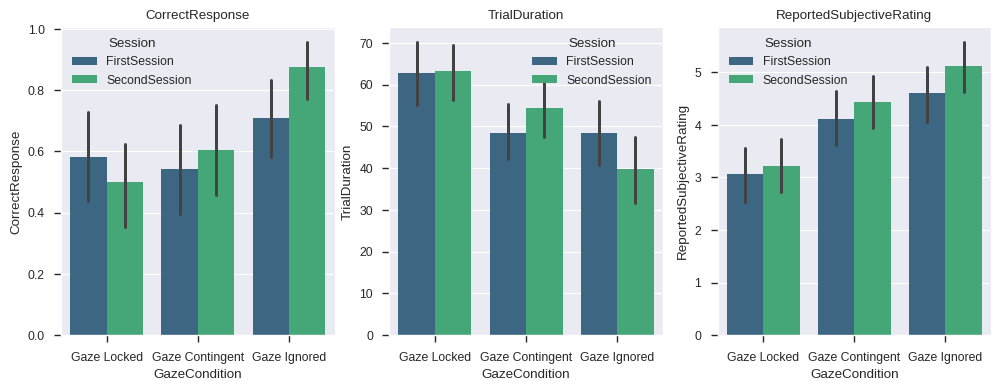

In [61]:
exclude_subjects = ['S40', 'S42', 'S50']
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

data = sr_data.copy()
if exclude_subjects is not None:
    data = data.loc[~data.Subject.isin(exclude_subjects)].copy()

fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Session', palette='viridis')
visualization.redefine_x_ticks(axs)

In [ ]:
TODO: TEST FOR LEARNING EFFECT AND INTERACTIONS 

#### Revisiting the same environment

In [73]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
exclude_subjects = ['S40', 'S42', 'S50']

data = sr_data.copy()
if exclude_subjects is not None:
    data = data.loc[~data.Subject.isin(exclude_subjects)].copy()
    
avg_seenbefore = data.loc[sr_data.Session == 'SecondSession'].groupby(['Subject']).SeenBeforeCount.sum().mean()
print(f'on average, {avg_seenbefore:.2f} of the 9 environments in the second session were seen before')

on average, 7.00 of the 9 environments in the second session were seen before


Text(0.5, 0.98, 'Second session')

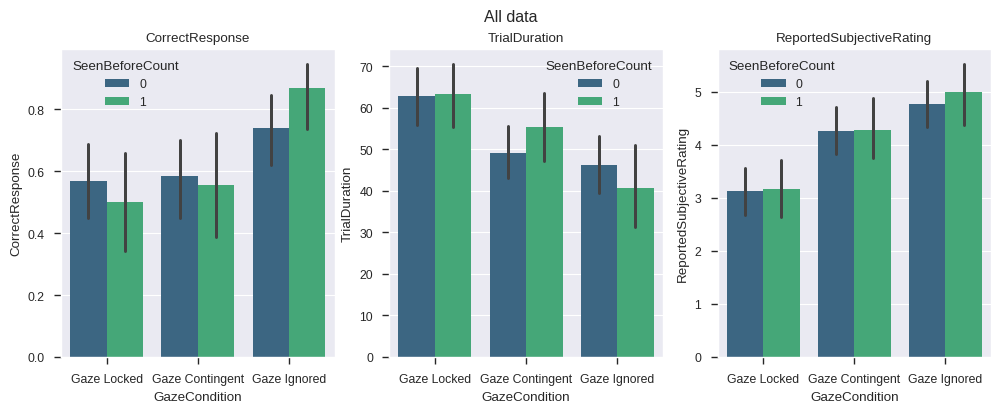

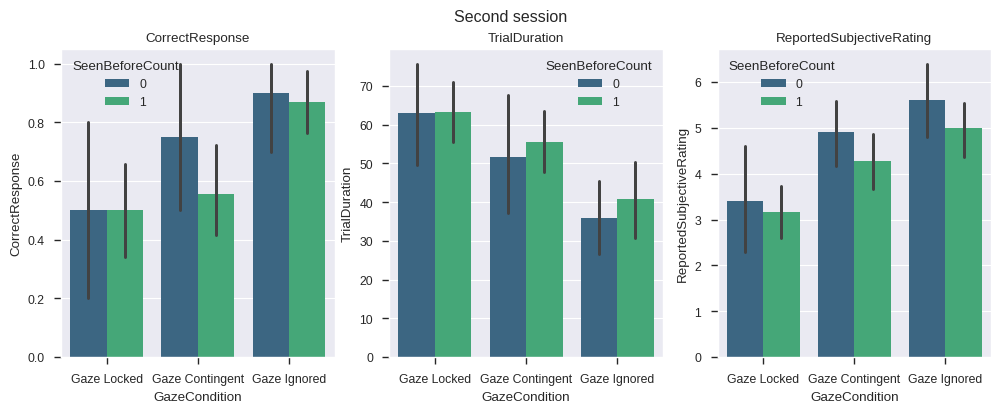

In [74]:
visualization.set_figurestyle()

fig, axs = visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='SeenBeforeCount', palette='viridis')
visualization.redefine_x_ticks(axs)
fig.suptitle('All data')

fig, axs = visualization.bar_plots(data=data.loc[data.Session =='SecondSession'], x='GazeCondition', endpoints=endpoints, hue='SeenBeforeCount', palette='viridis')
visualization.redefine_x_ticks(axs)
fig.suptitle('Second session')

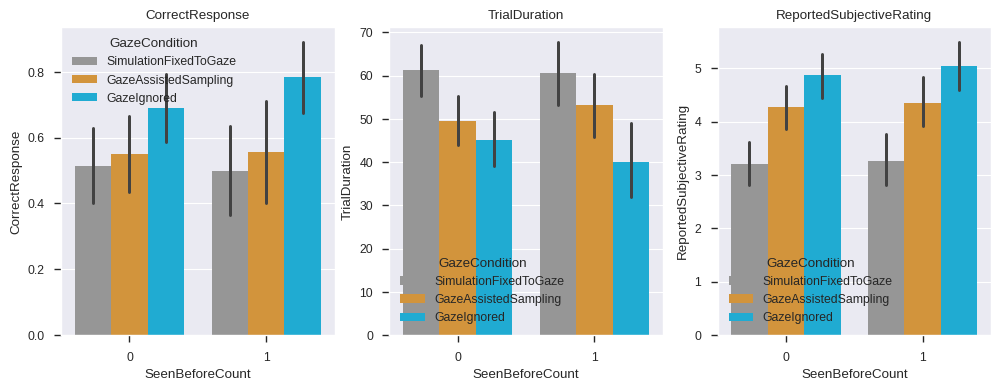

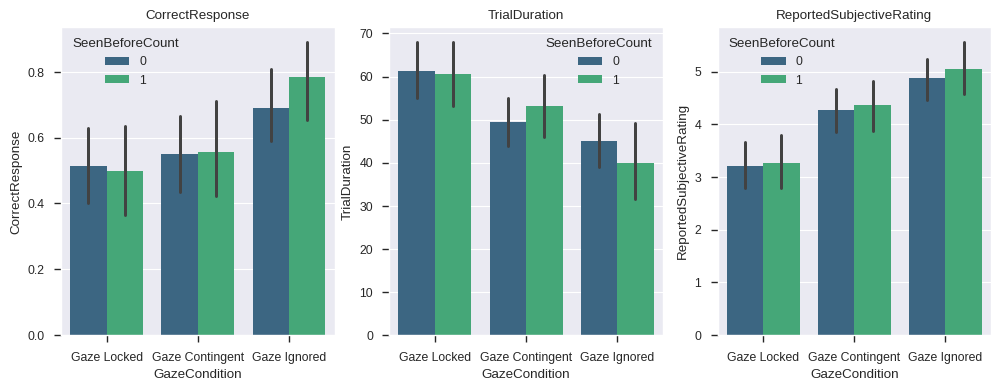

In [78]:
visualization.bar_plots(data=sr_data,x='SeenBeforeCount', endpoints=endpoints, order=None,
                        hue='GazeCondition', hue_order=visualization.ORDERED_CONDITIONS)

fig, axs = visualization.bar_plots(data=sr_data, x='GazeCondition', endpoints=endpoints, hue='SeenBeforeCount', palette='viridis')
visualization.redefine_x_ticks(axs)
plt.show()

<AxesSubplot: xlabel='GazeCondition', ylabel='CorrectResponse'>

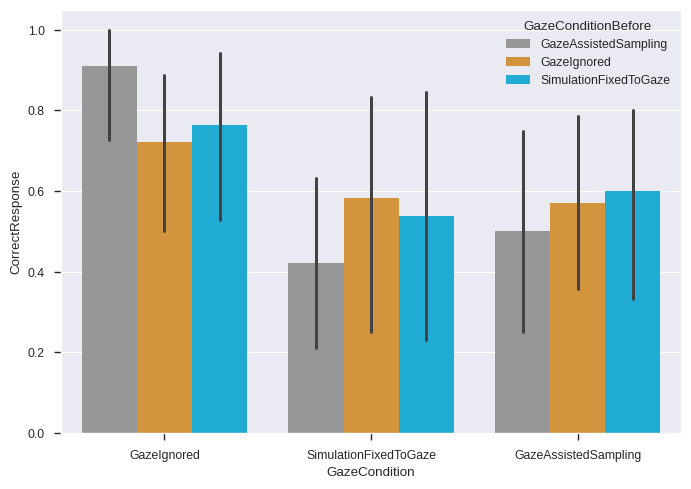

In [79]:
# Effect of previous condition
reindexed = sr_data.set_index(['Subject','EnvironmentName'])
first_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 0].copy()
second_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 1].copy() #pun not intended
before = first_sight.loc[second_sight.index]

second_sight['GazeConditionBefore'] = before.GazeCondition
second_sight['SameConditionBefore'] = before.GazeCondition == second_sight.GazeCondition
second_sight['CorrectBefore'] = before.CorrectResponse
second_sight['CorrectImprovement'] = before.CorrectResponse

sns.barplot(data=second_sight,x='GazeCondition', y='CorrectResponse', hue='GazeConditionBefore')

In [7]:
stats.paired_wilcoxon(data, group='Subject', endpoints=['ReportedSubjectiveRating', 'TrialDuration', 'CorrectResponse'])

,ReportedSubjectiveRating,TrialDuration,CorrectResponse
Gaze Ignored <> Gaze Contingent,9.138304e-04,5.863893e-03,0.004678
Gaze Contingent <> Gaze Locked,3.137562e-06,4.186237e-04,0.522053
Gaze Ignored <> Gaze Locked,3.391261e-11,9.324443e-09,0.001135


<AxesSubplot: xlabel='Block', ylabel='CorrectResponse'>

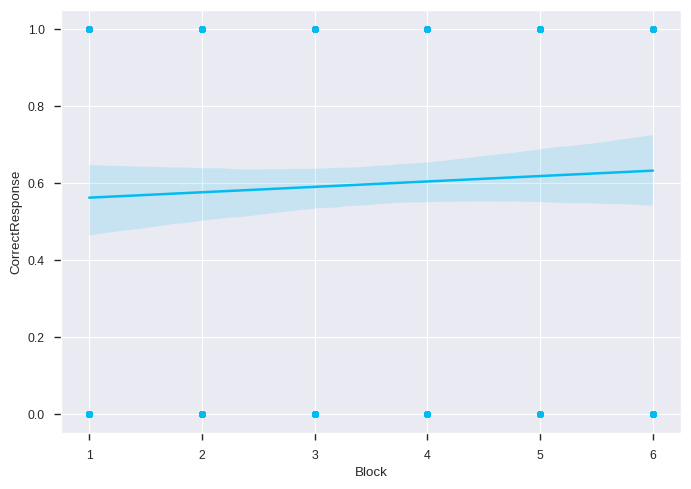

In [17]:
sns.regplot(data=data, x='Block', y='CorrectResponse')

<AxesSubplot: xlabel='Block', ylabel='CorrectResponse'>

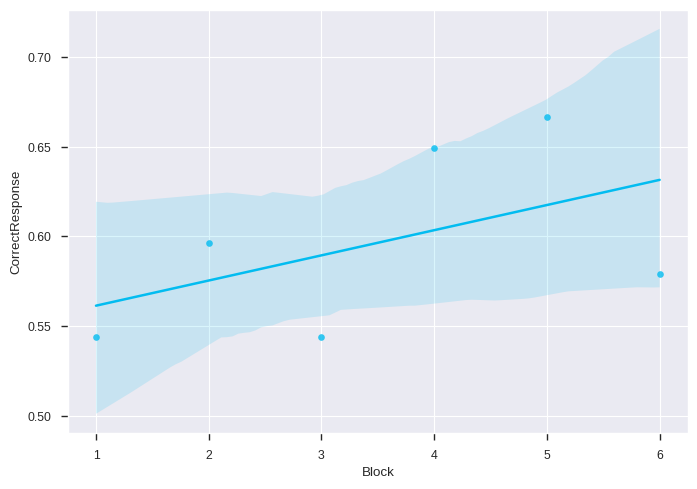

In [19]:
sns.regplot(data=data.groupby('Block')[['CorrectResponse']].mean().reset_index(), x='Block', y='CorrectResponse')
plt.

<AxesSubplot: xlabel='Subject', ylabel='CorrectResponse'>

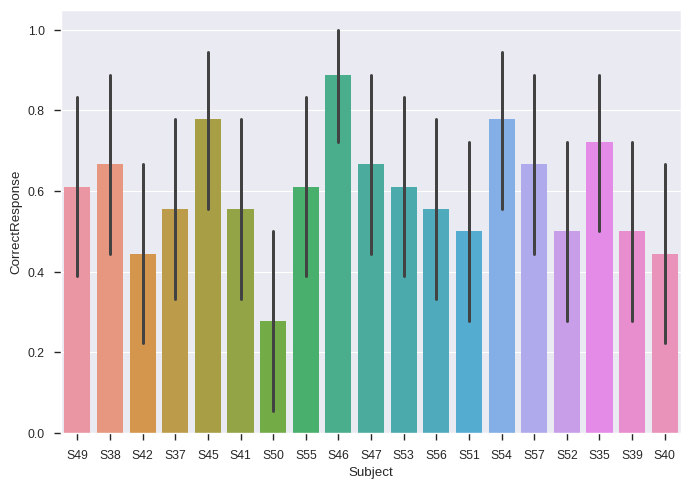

In [13]:
sns.barplot(data=data, x='Subject', y='CorrectResponse')

In [14]:
data.groupby('Subject').mean().CorrectResponse

/tmp/ipykernel_2474006/2266313959.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('Subject').mean().CorrectResponse


Subject
S35    0.722222
S37    0.555556
S38    0.666667
S39    0.500000
S40    0.444444
S41    0.555556
S42    0.444444
S45    0.777778
S46    0.888889
S47    0.666667
S49    0.611111
S50    0.277778
S51    0.500000
S52    0.500000
S53    0.611111
S54    0.777778
S55    0.611111
S56    0.555556
S57    0.666667
Name: CorrectResponse, dtype: float64

In [83]:
trial_config_data = exp_data['TrialConfigRecord']

eng_data = exp_data['EngineDataRecord'].copy()

In [88]:
trial_config_data[['ExperimentalTask','TrialDuration']].style

,ExperimentalTask,TrialDuration
0,FreePractice,300.004500
1,VisualSearch,90.002500
2,SceneRecognition,60.009160
3,VisualSearch,90.002500
4,SceneRecognition,60.006840
5,VisualSearch,90.002320
6,SceneRecognition,60.001590
7,FreePractice,150.006600
8,VisualSearch,90.002200
9,SceneRecognition,39.048460


In [89]:
300+90+90+90+150

720

In [81]:
practice_blocks = trial_config_data.loc[trial_config_data.Block == 0]

practice_blocks.groupby(['Subject', 'ExperimentalTask', 'EnvironmentName']).first().style

In [39]:
trial_config_data.groupby(['EnvironmentClass','EnvironmentName']).count()

ExperimentalTask  GazeCondition  Glasses  \
EnvironmentClass EnvironmentName                                             
Bathroom         bathroom_1                     28             28       28   
                 bathroom_2                     28             28       28   
                 bathroom_3                     31             31       31   
Bedroom          bedroom_1                      33             33       33   
                 bedroom_2                      31             31       31   
                 bedroom_3                      19             19       19   
                 bedroom_4                      29             29       29   
Kitchen          kitchen_1                      19             19       19   
                 kitchen_2                      23             23       23   
                 kitchen_3                      32             32       32   
Living           living_1                       30             30       30   
                 living_2                       28             28       28   
                 living_3                       28             28       28   
                 living_4                       31             31       31   
                 living_5                        9              9        9   
None             Playground                    377            377      377   

                                  GazeRaySensitivity  DataDelimiter  \
EnvironmentClass EnvironmentName                                      
Bathroom         bathroom_1                       28             28   
                 bathroom_2                       28             28   
                 bathroom_3                       31             31   
Bedroom          bedroom_1                        33             33   
                 bedroom_2                        31             31   
                 bedroom_3                        19             19   
                 bedroom_4                        29             29   
Kitchen          kitchen_1                        19             19   
                 kitchen_2                        23             23   
                 kitchen_3                        32             32   
Living           living_1                         30             30   
                 living_2                         28             28   
                 living_3                         28             28   
                 living_4                         31             31   
                 living_5                          9              9   
None             Playground                      377            377   

                                  ReportedRoomCategory  \
EnvironmentClass EnvironmentName                         
Bathroom         bathroom_1                         28   
                 bathroom_2                         28   
                 bathroom_3                         31   
Bedroom          bedroom_1                          33   
                 bedroom_2                          31   
                 bedroom_3                          19   
                 bedroom_4                          29   
Kitchen          kitchen_1                          19   
                 kitchen_2                          23   
                 kitchen_3                          32   
Living           living_1                           30   
                 living_2                           28   
                 living_3                           28   
                 living_4                           31   
                 living_5                            9   
None             Playground                        377   

                                  ReportedSubjectiveRating  \
EnvironmentClass EnvironmentName                             
Bathroom         bathroom_1                             28   
                 bathroom_2                             28   
                 bathroom_3                             3

In [75]:
trial_config_data.groupby(['EnvironmentClass','EnvironmentName']).count().index

MultiIndex([('Bathroom', 'bathroom_1'),
            ('Bathroom', 'bathroom_2'),
            ('Bathroom', 'bathroom_3'),
            ( 'Bedroom',  'bedroom_1'),
            ( 'Bedroom',  'bedroom_2'),
            ( 'Bedroom',  'bedroom_3'),
            ( 'Bedroom',  'bedroom_4'),
            ( 'Kitchen',  'kitchen_1'),
            ( 'Kitchen',  'kitchen_2'),
            ( 'Kitchen',  'kitchen_3'),
            (  'Living',   'living_1'),
            (  'Living',   'living_2'),
            (  'Living',   'living_3'),
            (  'Living',   'living_4'),
            (  'Living',   'living_5'),
            (    'None', 'Playground')],
           names=['EnvironmentClass', 'EnvironmentName'])

In [41]:
non_practice = trial_config_data.Block>0
trial_config_data.loc[~non_practice].groupby(['EnvironmentClass','EnvironmentName']).count()

ExperimentalTask  GazeCondition  Glasses  \
EnvironmentClass EnvironmentName                                             
Bedroom          bedroom_3                      19             19       19   
Kitchen          kitchen_1                      19             19       19   
                 kitchen_2                      10             10       10   
Living           living_5                        9              9        9   
None             Playground                     95             95       95   

                                  GazeRaySensitivity  DataDelimiter  \
EnvironmentClass EnvironmentName                                      
Bedroom          bedroom_3                        19             19   
Kitchen          kitchen_1                        19             19   
                 kitchen_2                        10             10   
Living           living_5                          9              9   
None             Playground                       95             95   

                                  ReportedRoomCategory  \
EnvironmentClass EnvironmentName                         
Bedroom          bedroom_3                          19   
Kitchen          kitchen_1                          19   
                 kitchen_2                          10   
Living           living_5                            9   
None             Playground                         95   

                                  ReportedSubjectiveRating  \
EnvironmentClass EnvironmentName                             
Bedroom          bedroom_3                              19   
Kitchen          kitchen_1                              19   
                 kitchen_2                              10   
Living           living_5                                9   
None             Playground                             95   

                                  ReportedEventsCount  TrialDuration  \
EnvironmentClass EnvironmentName                                       
Bedroom          bedroom_3                         19             19   
Kitchen          kitchen_1                         19             19   
                 kitchen_2                         10             10   
Living           living_5                           9              9   
None             Playground                        95             95   

                                  Unnamed: 11  Subject  Block  \
EnvironmentClass EnvironmentName                                
Bedroom          bedroom_3                  0       19     19   
Kitchen          kitchen_1                  0       19     19   
                 kitchen_2                  0       10     10   
Living           living_5                   0        9      9   
None             Playground                 0       95     95   

                                  RelativeTrialNumber  TrialIdentifier  
EnvironmentClass EnvironmentName                                        
Bedroom          bedroom_3                         19               19  
Kitchen          kitchen_1                         19               19  
                 kitchen_2                         10               10  
Living           living_5                           9                9  
None             Playground                        95               95

In [66]:
sr = trial_config_data.ExperimentalTask == 'SceneRecognition'
d = trial_config_data.loc[sr].copy()
d['CumCount'] = d.groupby(['Subject','EnvironmentName']).cumcount()

d[['Subject', 'Block', 'EnvironmentName', 'CumCount']].style

,Subject,Block,EnvironmentName,CumCount
2,S35,0,kitchen_1,0
4,S35,0,bedroom_3,0
6,S35,0,kitchen_2,0
9,S35,1,kitchen_3,0
10,S35,1,bedroom_2,0
11,S35,1,living_4,0
13,S35,2,living_2,0
14,S35,2,bedroom_4,0
15,S35,2,bathroom_2,0
17,S35,3,living_3,0


In [72]:
practice_blocks = d.loc[d.Block == 0].groupby(['Subject', 'EnvironmentName']).first()
experiment_blocks = d.loc[d.Block > 0].groupby(['Subject', 'EnvironmentName']).first()

practice_blocks.index.isin(experiment_blocks.index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [76]:
practice_blocks

ExperimentalTask          GazeCondition  \
Subject EnvironmentName                                            
S35     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S37     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S38     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S39     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S40     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S41     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S42     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S45     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S46     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S47     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        kitchen_2        SceneRecognition  SimulationFixedToGaze   
S49     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S50     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S51     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S52     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S53     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S54     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S55     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S56     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   
S57     bedroom_3        SceneRecognition   GazeAssistedSampling   
        kitchen_1        SceneRecognition            GazeIgnored   
        living_5         SceneRecognition  SimulationFixedToGaze   

            

In [ ]:
practice_blocks = d.loc[d.Block == 0].groupby(['Subject', 'EnvironmentName']).first()
for subj, subj_data in d.groupby('Subject'):
    practice_data = subj_data.loc[subj_data.Block == 0] 
    non_practice_data = subj_data.loc[subj_data.Block>0] 
    practice_data.EnvironmentName.isin(non_practice_data.EnvironmentName)

In [53]:
trial_config_data.groupby(['Subject','EnvironmentName']).EnvironmentName.transform('size')

0      20
1      20
2       1
3      20
4       1
       ..
771    20
772    20
773    20
774    20
775    20
Name: EnvironmentName, Length: 776, dtype: int64